# DATA PREPROCESSING

In [2]:
import pandas as pd
import sys
sys.path.append("C:/Users/Fernando/Desktop/Proyecto_Final_ML/src")
import preprocess_functions as pr

In [13]:
data = pd.read_csv("../data/data_train.csv", index_col=0)

###  Codificacion Columna Company Response

| Código | Respuesta de la Empresa             | Significado                                                                 |
|--------|-------------------------------------|------------------------------------------------------------------------------|
| 0      | Untimely response                   | La empresa no respondió dentro del plazo requerido.                         |
| 1      | In progress                         | La queja aún está siendo revisada; no hay respuesta final.                  |
| 2      | Closed with monetary relief         | Se cerró el caso con una compensación económica al consumidor.              |
| 3      | Closed with non-monetary relief     | Se cerró el caso con una solución no monetaria (ej. corrección de datos).   |
| 4      | Closed with explanation             | Se cerró el caso solo con una explicación, sin acción correctiva.           |
| 5      | Closed                              | Se cerró el caso sin detalles claros sobre la resolución.                   |

#### Como Target podemos usar la variable respuesta de la compañía para saber si esta será respondida con solucion (Closed with monetary relief, Closed with non-monetary relief), si será cerrada sin efecto (Closed with explanation, Closed). Por otro lado vamos a eliminar las categorías de Untimely response y In progress, ya que no aportan información sobre la importancia de si se debe atender una queja o no.

### Predecir esta clasificación va a permitir saber si la queja es importante (cerrada con solución) o no (cerrada sin efecto)

In [3]:
data_company_response_binary = data[~data["Company response"].isin(["In progress", "Untimely response"])]

In [4]:
# Creación del diccionario con los valores para codificar la columna Company reponse.
estado_respuesta = {'Closed with monetary relief': 0, 
       'Closed with non-monetary relief':0, 'Closed with explanation': 1, 'Closed': 1}

In [5]:
# Transformación de la columna Company Response en numérica

data_company_response_binary["Company response"] = data_company_response_binary["Company response"].map(estado_respuesta)

C:\Users\Fernando\AppData\Local\Temp\ipykernel_13180\1802730481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_company_response_binary["Company response"] = data_company_response_binary["Company response"].map(estado_respuesta)


In [6]:
data_company_response_binary["Company response"].value_counts(normalize=True)

Company response
1    0.797595
0    0.202405
Name: proportion, dtype: float64

## Split Data in train and test

In [7]:
from sklearn.model_selection import train_test_split

X = data_company_response_binary.drop(columns=["Company response"])
y = data_company_response_binary["Company response"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

# FEATURE ENGINEERING

### Feature: Sub-product

In [36]:
# First, fill missing values in the Sub-product column with the value "Non subproduct" 
# With this we're creating a new class that will be encoded in the next step

X_train['Sub-product'] = X_train['Sub-product'].fillna("No subproduct")
X_test["Sub-product"] = X_test["Sub-product"].fillna("No subproduct")

In [37]:
## TARGET ENCODER

from sklearn.preprocessing import TargetEncoder

In [ ]:
# Instantiate the encoder with smooth and crossvalidation to regularization
encoder = TargetEncoder(categories="auto", smooth="auto", cv= 5, random_state=42)

# Fit train
encoder.fit(X_train[["Sub-product"]], y_train)

# Transform train and test. We get 1 column for each row 
# based on the conditional probability estimate for each class

subproduct_encoder_train = encoder.transform(X_train[["Sub-product"]])
subproduct_encoder_test = encoder.transform(X_test[["Sub-product"]])

In [39]:
# Creating new columns with Sub-product endoded in X_train

for matrix in range(subproduct_encoder_train.shape[1]):
    X_train[f"subproduct_class{matrix}_enc"] = subproduct_encoder_train[:,matrix]


In [40]:
# Creating new columns with Sub-product endoded in X_test

for matrix in range(subproduct_encoder_test.shape[1]):
    X_test[f"subproduct_class{matrix}_enc"] = subproduct_encoder_test[:,matrix]

## Feature: ZIP code

In [41]:
# First, we change the type of ZIP code from float to string

X_train["ZIP code"] = X_train["ZIP code"].apply(pr.zip_to_string)
X_test["ZIP code"] = X_test["ZIP code"].apply(pr.zip_to_string)

In [ ]:
# Second, we get se State using the ZIP code as long as it's possible where State values are missing but we know the postcode.
# We use a function that search into the API zippzippopotam.

X_train = pr.search_state_from_zip(X_train, "ZIP code", "State")
X_test = pr.search_state_from_zip(X_test, "ZIP code", "State")


ZIP code 795 not found in API.
ZIP code 986 not found in API.
ZIP code 09620 not found in API.
ZIP code 19 not found in API.
ZIP code 782 not found in API.
ZIP code 745 not found in API.
ZIP code 24 not found in API.
ZIP code 960 not found in API.
ZIP code 11000 not found in API.
ZIP code 40002 not found in API.
ZIP code 53240 not found in API.
ZIP code 09354 not found in API.
ZIP code 336 not found in API.
ZIP code 907 not found in API.
ZIP code 715 not found in API.
ZIP code 96502 not found in API.
ZIP code 30419 not found in API.
ZIP code 18536 not found in API.
ZIP code 11 not found in API.
ZIP code 915 not found in API.
ZIP code 20 not found in API.
ZIP code 795 not found in API.
ZIP code 719 not found in API.
ZIP code 100 not found in API.
ZIP code 424 not found in API.
ZIP code 795 not found in API.
ZIP code 609 not found in API.
ZIP code 12000 not found in API.
ZIP code 921 not found in API.
ZIP code 907 not found in API.


In [43]:
pr.search_city_from_zip(X_train, "ZIP code")

creating city column


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Timely response?,Consumer disputed?,subproduct_class0_enc,city_column
10239,1237398,Mortgage,VA mortgage,"Loan servicing, payments, escrow account",NaN,AZ,85301,2015-02-12,2015-02-12,Dovenmuehle Mortgage Inc.,Yes,NaN,0.898418,Glendale
26727,1181802,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,AZ,85020,2015-01-06,2015-01-06,Wells Fargo,Yes,Yes,0.927206,Phoenix
22429,1196197,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,IL,60608,2015-01-15,2015-01-15,Round Point Mortgage,Yes,Yes,0.927206,Chicago
6631,1250239,Bank account or service,Cashing a check without an account,Deposits and withdrawals,NaN,CA,91355,2015-02-20,2015-02-23,Wells Fargo,Yes,NaN,0.912154,Valencia
23535,1201036,Credit card,No subproduct,Transaction issue,NaN,PA,19118,2015-01-13,2015-01-13,U.S. Bancorp,Yes,NaN,0.725821,Philadelphia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14063,1224530,Credit reporting,No subproduct,Incorrect information on credit report,Public record,CA,90805,2015-02-04,2015-02-09,Equifax,Yes,Yes,0.725821,Long Beach
11874,1231599,Debt collection,No subproduct,Disclosure verification of debt,Not given enough info to verify debt,SC,29073,2015-02-09,2015-02-09,HSBC,Yes,NaN,0.725821,Lexington
191,1283362,Credit reporting,No subproduct,Incorrect information on credit report,Account terms,WI,53051,2015-03-14,2015-03-14,TransUnion,Yes,NaN,0.725821,Menomonee Falls
10786,1235075,Credit reporting,No subproduct,Incorrect information on credit report,Information is not mine,NC,28025,2015-02-11,2015-02-18,Equifax,Yes,NaN,0.725821,Concord


When we transform ZIP Code in to name of city we reduce the cardinality from >7000 to <2000 but missing values increase from 179 to 1722. The increasing of missing value migth be because some of the ZIP code were recorded incorrectly. In addition some of the states couldn't be extracted from the ZIP code, that could happened for the same reason.

In [44]:
# Creating the city column in the X_test partition
pr.search_city_from_zip(X_test, "ZIP code")


creating city column


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Timely response?,Consumer disputed?,subproduct_class0_enc,city_column
4795,1256841,Debt collection,Medical,Disclosure verification of debt,Right to dispute notice not received,TX,78660,2015-02-25,2015-02-25,Medical Business Bureau,Yes,Yes,0.889836,Pflugerville
26352,1182937,Credit reporting,No subproduct,Incorrect information on credit report,Account status,FL,92585,2015-01-06,2015-02-09,Equifax,Yes,NaN,0.725821,Sun City
22570,1194703,Debt collection,"Other (phone, health club, etc.)",Disclosure verification of debt,Not disclosed as an attempt to collect,TX,76012,2015-01-15,2015-01-21,AllianceOne Recievables Management,Yes,Yes,0.708945,Arlington
12375,1229985,Debt collection,"Other (phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,KY,40353,2015-02-07,2015-02-11,"National Credit Systems,Inc.",Yes,NaN,0.708945,Mount Sterling
3783,1260607,Consumer loan,Vehicle loan,Managing the loan or lease,NaN,CO,80107,2015-02-27,2015-03-04,"Prestige Financial Services, Inc.",Yes,NaN,0.857732,Elizabeth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12112,1232082,Credit reporting,No subproduct,Incorrect information on credit report,Information is not mine,CA,90744,2015-02-09,2015-02-09,Equifax,Yes,NaN,0.725821,Wilmington
18004,1212398,Credit reporting,No subproduct,Credit reporting company's investigation,Problem with statement of dispute,VA,22963,2015-01-27,2015-01-27,TransUnion,Yes,NaN,0.725821,Palmyra
3574,1261189,Debt collection,"Other (phone, health club, etc.)",Communication tactics,Frequent or repeated calls,IL,60618,2015-02-27,2015-03-02,"Enhanced Recovery Company, LLC",Yes,NaN,0.708945,Chicago
25722,1184318,Debt collection,Payday loan,Communication tactics,Called after sent written cease of comm,NM,87042,2015-01-07,2015-01-07,Western-Shamrock Corporation,Yes,No,0.889155,Peralta


In [45]:
pr.get_county_from_zip(X_train, "ZIP code")

ZIP code 75033 not found in API.
ZIP code 801 not found in API.
ZIP code 957 not found in API.
ZIP code 985 not found in API.
ZIP code 01087 not found in API.
ZIP code 60207 not found in API.
ZIP code 725 not found in API.
ZIP code 918 not found in API.
ZIP code 677 not found in API.
ZIP code 78844 not found in API.
ZIP code 978 not found in API.
ZIP code 88365 not found in API.
ZIP code 795 not found in API.
ZIP code 715 not found in API.
ZIP code 986 not found in API.
ZIP code 9 not found in API.
ZIP code 96205 not found in API.
ZIP code 966 not found in API.
ZIP code 977 not found in API.
ZIP code 662 not found in API.
ZIP code 32883 not found in API.
ZIP code 52589 not found in API.
ZIP code 55022 not found in API.
ZIP code 90532 not found in API.
ZIP code 96672 not found in API.
ZIP code 84129 not found in API.
ZIP code 678 not found in API.
ZIP code 12354 not found in API.
ZIP code 79612 not found in API.
ZIP code 913 not found in API.
ZIP code 96319 not found in API.
ZIP code 77

,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Timely response?,Consumer disputed?,subproduct_class0_enc,city_column,county
10239,1237398,Mortgage,VA mortgage,"Loan servicing, payments, escrow account",NaN,AZ,85301,2015-02-12,2015-02-12,Dovenmuehle Mortgage Inc.,Yes,NaN,0.898418,Glendale,Maricopa
26727,1181802,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,AZ,85020,2015-01-06,2015-01-06,Wells Fargo,Yes,Yes,0.927206,Phoenix,Maricopa
22429,1196197,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,IL,60608,2015-01-15,2015-01-15,Round Point Mortgage,Yes,Yes,0.927206,Chicago,Cook
6631,1250239,Bank account or service,Cashing a check without an account,Deposits and withdrawals,NaN,CA,91355,2015-02-20,2015-02-23,Wells Fargo,Yes,NaN,0.912154,Valencia,Los Angeles
23535,1201036,Credit card,No subproduct,Transaction issue,NaN,PA,19118,2015-01-13,2015-01-13,U.S. Bancorp,Yes,NaN,0.725821,Philadelphia,Philadelphia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14063,1224530,Credit reporting,No subproduct,Incorrect information on credit report,Public record,CA,90805,2015-02-04,2015-02-09,Equifax,Yes,Yes,0.725821,Long Beach,Los Angeles
11874,1231599,Debt collection,No subproduct,Disclosure verification of debt,Not given enough info to verify debt,SC,29073,2015-02-09,2015-02-09,HSBC,Yes,NaN,0.725821,Lexington,Lexington
191,1283362,Credit reporting,No subproduct,Incorrect information on credit report,Account terms,WI,53051,2015-03-14,2015-03-14,TransUnion,Yes,NaN,0.725821,Menomonee Falls,Waukesha
10786,1235075,Credit reporting,No subproduct,Incorrect information on credit report,Information is not mine,NC,28025,2015-02-11,2015-02-18,Equifax,Yes,NaN,0.725821,Concord,Cabarrus


In [46]:
pr.get_county_from_zip(X_test, "ZIP code")

ZIP code 09012 not found in API.
ZIP code 20 not found in API.
ZIP code 682 not found in API.
ZIP code 10568 not found in API.
ZIP code 795 not found in API.
ZIP code 719 not found in API.
ZIP code 926 not found in API.
ZIP code 100 not found in API.
ZIP code 01212 not found in API.
ZIP code 424 not found in API.
ZIP code 95284 not found in API.
ZIP code 771 not found in API.
ZIP code 96548 not found in API.
ZIP code 985 not found in API.
ZIP code 977 not found in API.
ZIP code 47753 not found in API.
ZIP code 609 not found in API.
ZIP code 65407 not found in API.
ZIP code 979 not found in API.
ZIP code 43714 not found in API.
ZIP code 603 not found in API.
ZIP code 950 not found in API.
ZIP code 96517 not found in API.
ZIP code 01696 not found in API.
ZIP code 949 not found in API.
ZIP code 66379 not found in API.
ZIP code 12000 not found in API.
ZIP code 921 not found in API.
ZIP code 907 not found in API.
ZIP code 08575 not found in API.


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Timely response?,Consumer disputed?,subproduct_class0_enc,city_column,county
4795,1256841,Debt collection,Medical,Disclosure verification of debt,Right to dispute notice not received,TX,78660,2015-02-25,2015-02-25,Medical Business Bureau,Yes,Yes,0.889836,Pflugerville,Travis
26352,1182937,Credit reporting,No subproduct,Incorrect information on credit report,Account status,FL,92585,2015-01-06,2015-02-09,Equifax,Yes,NaN,0.725821,Sun City,Riverside
22570,1194703,Debt collection,"Other (phone, health club, etc.)",Disclosure verification of debt,Not disclosed as an attempt to collect,TX,76012,2015-01-15,2015-01-21,AllianceOne Recievables Management,Yes,Yes,0.708945,Arlington,Tarrant
12375,1229985,Debt collection,"Other (phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,KY,40353,2015-02-07,2015-02-11,"National Credit Systems,Inc.",Yes,NaN,0.708945,Mount Sterling,Montgomery
3783,1260607,Consumer loan,Vehicle loan,Managing the loan or lease,NaN,CO,80107,2015-02-27,2015-03-04,"Prestige Financial Services, Inc.",Yes,NaN,0.857732,Elizabeth,Elbert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12112,1232082,Credit reporting,No subproduct,Incorrect information on credit report,Information is not mine,CA,90744,2015-02-09,2015-02-09,Equifax,Yes,NaN,0.725821,Wilmington,Los Angeles
18004,1212398,Credit reporting,No subproduct,Credit reporting company's investigation,Problem with statement of dispute,VA,22963,2015-01-27,2015-01-27,TransUnion,Yes,NaN,0.725821,Palmyra,Fluvanna
3574,1261189,Debt collection,"Other (phone, health club, etc.)",Communication tactics,Frequent or repeated calls,IL,60618,2015-02-27,2015-03-02,"Enhanced Recovery Company, LLC",Yes,NaN,0.708945,Chicago,Cook
25722,1184318,Debt collection,Payday loan,Communication tactics,Called after sent written cease of comm,NM,87042,2015-01-07,2015-01-07,Western-Shamrock Corporation,Yes,No,0.889155,Peralta,Valencia


## Feature: Dates

In [47]:
import datetime

In [48]:
## Transform the date columns into datetime values
pr.date_converter(X_train, "Date received", "Date sent to company")
pr.date_converter(X_test, "Date received", "Date sent to company")


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Timely response?,Consumer disputed?,subproduct_class0_enc,city_column,county
4795,1256841,Debt collection,Medical,Disclosure verification of debt,Right to dispute notice not received,TX,78660,2015-02-25,2015-02-25,Medical Business Bureau,Yes,Yes,0.889836,Pflugerville,Travis
26352,1182937,Credit reporting,No subproduct,Incorrect information on credit report,Account status,FL,92585,2015-01-06,2015-02-09,Equifax,Yes,NaN,0.725821,Sun City,Riverside
22570,1194703,Debt collection,"Other (phone, health club, etc.)",Disclosure verification of debt,Not disclosed as an attempt to collect,TX,76012,2015-01-15,2015-01-21,AllianceOne Recievables Management,Yes,Yes,0.708945,Arlington,Tarrant
12375,1229985,Debt collection,"Other (phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,KY,40353,2015-02-07,2015-02-11,"National Credit Systems,Inc.",Yes,NaN,0.708945,Mount Sterling,Montgomery
3783,1260607,Consumer loan,Vehicle loan,Managing the loan or lease,NaN,CO,80107,2015-02-27,2015-03-04,"Prestige Financial Services, Inc.",Yes,NaN,0.857732,Elizabeth,Elbert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12112,1232082,Credit reporting,No subproduct,Incorrect information on credit report,Information is not mine,CA,90744,2015-02-09,2015-02-09,Equifax,Yes,NaN,0.725821,Wilmington,Los Angeles
18004,1212398,Credit reporting,No subproduct,Credit reporting company's investigation,Problem with statement of dispute,VA,22963,2015-01-27,2015-01-27,TransUnion,Yes,NaN,0.725821,Palmyra,Fluvanna
3574,1261189,Debt collection,"Other (phone, health club, etc.)",Communication tactics,Frequent or repeated calls,IL,60618,2015-02-27,2015-03-02,"Enhanced Recovery Company, LLC",Yes,NaN,0.708945,Chicago,Cook
25722,1184318,Debt collection,Payday loan,Communication tactics,Called after sent written cease of comm,NM,87042,2015-01-07,2015-01-07,Western-Shamrock Corporation,Yes,No,0.889155,Peralta,Valencia


In [49]:
## Extract from the dates when the clients made the complaint the day of the month, day of the week and
## if it was on weekend or it isn't

pr.day_of_week_and_month(X_train, "Date received")
pr.day_of_week_and_month(X_test, "Date received" )

,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Timely response?,Consumer disputed?,subproduct_class0_enc,city_column,county,Date received_day_of_month,Date received_day_week,Date received_weekend
4795,1256841,Debt collection,Medical,Disclosure verification of debt,Right to dispute notice not received,TX,78660,2015-02-25,2015-02-25,Medical Business Bureau,Yes,Yes,0.889836,Pflugerville,Travis,25,2,0
26352,1182937,Credit reporting,No subproduct,Incorrect information on credit report,Account status,FL,92585,2015-01-06,2015-02-09,Equifax,Yes,NaN,0.725821,Sun City,Riverside,6,1,0
22570,1194703,Debt collection,"Other (phone, health club, etc.)",Disclosure verification of debt,Not disclosed as an attempt to collect,TX,76012,2015-01-15,2015-01-21,AllianceOne Recievables Management,Yes,Yes,0.708945,Arlington,Tarrant,15,3,0
12375,1229985,Debt collection,"Other (phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,KY,40353,2015-02-07,2015-02-11,"National Credit Systems,Inc.",Yes,NaN,0.708945,Mount Sterling,Montgomery,7,5,1
3783,1260607,Consumer loan,Vehicle loan,Managing the loan or lease,NaN,CO,80107,2015-02-27,2015-03-04,"Prestige Financial Services, Inc.",Yes,NaN,0.857732,Elizabeth,Elbert,27,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12112,1232082,Credit reporting,No subproduct,Incorrect information on credit report,Information is not mine,CA,90744,2015-02-09,2015-02-09,Equifax,Yes,NaN,0.725821,Wilmington,Los Angeles,9,0,0
18004,1212398,Credit reporting,No subproduct,Credit reporting company's investigation,Problem with statement of dispute,VA,22963,2015-01-27,2015-01-27,TransUnion,Yes,NaN,0.725821,Palmyra,Fluvanna,27,1,0
3574,1261189,Debt collection,"Other (phone, health club, etc.)",Communication tactics,Frequent or repeated calls,IL,60618,2015-02-27,2015-03-02,"Enhanced Recovery Company, LLC",Yes,NaN,0.708945,Chicago,Cook,27,4,0
25722,1184318,Debt collection,Payday loan,Communication tactics,Called after sent written cease of comm,NM,87042,2015-01-07,2015-01-07,Western-Shamrock Corporation,Yes,No,0.889155,Peralta,Valencia,7,2,0


In [50]:
# Extract from the date when the company received the complaint, the the day of the month, 
# day of the week and if it was on weekend or it isn't

pr.day_of_week_and_month(X_train, "Date sent to company")
pr.day_of_week_and_month(X_test, "Date sent to company")

,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,...,Consumer disputed?,subproduct_class0_enc,city_column,county,Date received_day_of_month,Date received_day_week,Date received_weekend,Date sent to company_day_of_month,Date sent to company_day_week,Date sent to company_weekend
4795,1256841,Debt collection,Medical,Disclosure verification of debt,Right to dispute notice not received,TX,78660,2015-02-25,2015-02-25,Medical Business Bureau,...,Yes,0.889836,Pflugerville,Travis,25,2,0,25,2,0
26352,1182937,Credit reporting,No subproduct,Incorrect information on credit report,Account status,FL,92585,2015-01-06,2015-02-09,Equifax,...,NaN,0.725821,Sun City,Riverside,6,1,0,9,0,0
22570,1194703,Debt collection,"Other (phone, health club, etc.)",Disclosure verification of debt,Not disclosed as an attempt to collect,TX,76012,2015-01-15,2015-01-21,AllianceOne Recievables Management,...,Yes,0.708945,Arlington,Tarrant,15,3,0,21,2,0
12375,1229985,Debt collection,"Other (phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,KY,40353,2015-02-07,2015-02-11,"National Credit Systems,Inc.",...,NaN,0.708945,Mount Sterling,Montgomery,7,5,1,11,2,0
3783,1260607,Consumer loan,Vehicle loan,Managing the loan or lease,NaN,CO,80107,2015-02-27,2015-03-04,"Prestige Financial Services, Inc.",...,NaN,0.857732,Elizabeth,Elbert,27,4,0,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12112,1232082,Credit reporting,No subproduct,Incorrect information on credit report,Information is not mine,CA,90744,2015-02-09,2015-02-09,Equifax,...,NaN,0.725821,Wilmington,Los Angeles,9,0,0,9,0,0
18004,1212398,Credit reporting,No subproduct,Credit reporting company's investigation,Problem with statement of dispute,VA,22963,2015-01-27,2015-01-27,TransUnion,...,NaN,0.725821,Palmyra,Fluvanna,27,1,0,27,1,0
3574,1261189,Debt collection,"Other (phone, health club, etc.)",Communication tactics,Frequent or repeated calls,IL,60618,2015-02-27,2015-03-02,"Enhanced Recovery Company, LLC",...,NaN,0.708945,Chicago,Cook,27,4,0,2,0,0
25722,1184318,Debt collection,Payday loan,Communication tactics,Called after sent written cease of comm,NM,87042,2015-01-07,2015-01-07,Western-Shamrock Corporation,...,No,0.889155,Peralta,Valencia,7,2,0,7,2,0


# **CHECK POINT 1**

# GUARDAMOS EL DATA X_TRAIN Y X_TEST CON LAS MODIFICACIONES HECHAS HASTA AHORA:

- "SUB PRODUCT" -> codificacion con Target encoder, tenemos 3 columnas con valores numericos
- "ZIP CODE" -> 
    - Búsqueda de estados faltantes a partir de zip codes.
    - Extracción del nombre de ciudades
    - Extracción del nombre de condados
* Hay que tener en cuenta que esos nombres no están codificados. Es posible que algunos zip codes no hayan sido detectados por las APIs utilizadas y no se haya podido extraer la información a aprtir de ellos. También es importante recordar que algunos lugares son fuera del continente norteamericado, por tanto deben ser agrupados de alguna manera. Y también los zip codes cambian.
- "DATES" -> Se ha extraido de las dos columnas con fechas los días de la semana, día del mes y si es fin de semana o no.

In [51]:
# Guardamos las particiones con las modificaciones realizadas hasta ahora

X_train.to_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_train_1")
X_test.to_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_test_1")

In [ ]:
# Carga de archivos generados X_train_1 y X_test_1

import pandas as pd
import preprocess_functions as pr

X_train = pd.read_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_train_1", index_col=0)
X_test = pd.read_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_test_1", index_col=0)

In [53]:
# Drop the columns "Date received" and "Date sent to company"

X_train = X_train.drop(columns=["Date received", "Date sent to company"])
X_test = X_test.drop(columns=["Date received", "Date sent to company"])

In [54]:
# Drop the column "ZIP code"
X_train = X_train.drop(columns=["ZIP code"])
X_test = X_test.drop(columns=["ZIP code"])

In [55]:
# Drop the column "Sub-product"

X_train = X_train.drop(columns=["Sub-product"])
X_test = X_test.drop(columns=["Sub-product"])

## Feature: Product

In [56]:
# Encoding with get dummies from pandas, 0 or 1 to indicate False or True, respectively

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output= False, dtype= int)

X_train_encoded = encoder.fit_transform(X_train[["Product"]])
X_test_encoded = encoder.transform(X_test[["Product"]])

X_train_ohe = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(["Product"]), index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(["Product"]), index=X_test.index)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)


## Feature: State


In [57]:
# In order to reduce cardinality in the column "state" we use the polical division proposed by The U.S. Census Bureau
# (https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf)
# This organizes the USA terrotory in regions and division to facilitate the statistical analyses.
# The regions out of the USA territory will be cataloged like "No state"

''' 
estados_usa = ['WI', 'AZ', 'CA', 'OH', 'GA', 'CT', 'CO', 'IL', 'IN', 'TX', 'MO',
    'NY', 'MA', 'NJ', 'LA', 'AL', 'FL', 'SC', 'TN', 'UT', 'MI', 'VA',
    'WA', 'NV', 'DE', 'MD', 'PA', 'OR', 'ID', 'OK', 'MN', 'AR', 'NC',
    'NH', 'IA', 'KS', 'ME', 'RI', 'NM', 'NE', 'WY', 'HI', 'KY', 'VT',
    'SD', 'MT', 'MS', 'WV', 'AK', 'ND', 'DC']


no_estados = ['AE', 'GU', 'PR', 'VI', 'AP', 'MH']

'''

" \nestados_usa = ['WI', 'AZ', 'CA', 'OH', 'GA', 'CT', 'CO', 'IL', 'IN', 'TX', 'MO',\n    'NY', 'MA', 'NJ', 'LA', 'AL', 'FL', 'SC', 'TN', 'UT', 'MI', 'VA',\n    'WA', 'NV', 'DE', 'MD', 'PA', 'OR', 'ID', 'OK', 'MN', 'AR', 'NC',\n    'NH', 'IA', 'KS', 'ME', 'RI', 'NM', 'NE', 'WY', 'HI', 'KY', 'VT',\n    'SD', 'MT', 'MS', 'WV', 'AK', 'ND', 'DC']\n\n\nno_estados = ['AE', 'GU', 'PR', 'VI', 'AP', 'MH']\n\n"

In [58]:
# Creation of two variables from state feature: region and division. This are two different types of
# organization based on  U.S. Census Bureau  which let us to reduce the cardinality of the feature state.
# Those states that are not in the USA territory get the feature "No state"

X_train, X_test = pr.region_and_division_creator(X_train, X_test, "State")


# Drop the column "State"

X_train = X_train.drop(columns=["State"])
X_test = X_test.drop(columns=["State"])

## Feature: Issue

In [59]:
import io
import os
import re
import string
import tensorflow as tf

In [60]:
# Preprocessing of the text:

'''  
This function preprocesses the input text by:
    - Converting to lowercase
    - Replacing commas with spaces
    - Keeping apostrophes as is
    - Removing all other punctuation characters
    - Removing stopwords
    Returns the cleaned text as a single string.

'''
X_train["Issue_tokens"] = X_train["Issue"].apply(pr.preprocessing_text)
X_test["Issue_tokens"] = X_test["Issue"].apply(pr.preprocessing_text)

In [1]:
# Training the word2Vec

from gensim.models import Word2Vec

In [62]:
# Training modelo Word2Vec
w2v_model_train = Word2Vec(
    sentences=X_train["Issue_tokens"],   # lista de listas de tokens
    vector_size=25,          # tamaño del vector
    window=5,                 # contexto
    min_count=1,              # palabra mínima para incluir
    workers=4                 # hilos
)

w2v_model_test = Word2Vec(
    sentences=X_test["Issue_tokens"],   # lista de listas de tokens
    vector_size=25,          # tamaño del vector
    window=5,                 # contexto
    min_count=1,              # palabra mínima para incluir
    workers=4                 # hilos
)


In [63]:
# Convertir cada texto a un embedding promedio
''' 
get_sentence_vector(tokens)

tokens es una lista de palabras ya separadas (por ejemplo, ["hola", "mundo"]).

vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
Aquí recorre cada palabra y, si existe en el modelo Word2Vec (w2v_model), obtiene su vector.

Si ninguna palabra está en el vocabulario (len(vectors) == 0), devuelve un vector de ceros con el mismo tamaño que los embeddings (np.zeros(w2v_model.vector_size)).

Si sí hay palabras válidas, calcula el promedio de todos esos vectores (np.mean(vectors, axis=0)).

X_train['embedding'] = X_train["Issue_tokens"].apply(get_sentence_vector)

A la columna "Issue_tokens" (que contiene listas de palabras) le aplica esa función y guarda el resultado en una nueva columna "embedding".

El resultado es que cada fila ahora tiene un vector numérico que representa el texto promedio de sus palabras.
'''

import numpy as np

# X train
def get_sentence_vector_train(tokens):
    vectors = [w2v_model_train.wv[word] for word in tokens if word in w2v_model_train.wv]
    if len(vectors) == 0:
        return np.zeros(w2v_model_train.vector_size)
    return np.mean(vectors, axis=0)

X_train['embedding'] = X_train["Issue_tokens"].apply(get_sentence_vector_train)

# X test

def get_sentence_vector_test(tokens):
    vectors = [w2v_model_train.wv[word] for word in tokens if word in w2v_model_test.wv]
    if len(vectors) == 0:
        return np.zeros(w2v_model_test.vector_size)
    return np.mean(vectors, axis=0)

X_test['embedding'] = X_test["Issue_tokens"].apply(get_sentence_vector_test)


In [64]:
# Creamos columnas con los valores de los vectores

# X_train
X_train_embedding = np.vstack(X_train['embedding'].values)

embedding_train_df = pd.DataFrame(X_train_embedding,
    columns=[f'embedding_{i}' for i in range(X_train_embedding.shape[1])])

# Hay que rehacer los índices, si no, al concatenar, se producirán NaN porque pandas intentará alinear
# por índice y se hará un lio
X_train = X_train.reset_index(drop=True)
embedding_train_df = embedding_train_df.reset_index(drop=True)

X_train = pd.concat([X_train.drop(columns=["Issue"]), embedding_train_df], axis=1)


# X_tets
X_test_embedding = np.vstack(X_test['embedding'].values) 
# Creamos una matriz 2D a partir de la columna de valores de embeddings

embedding_test_df = pd.DataFrame(X_test_embedding,
    columns=[f'embedding_{i}' for i in range(X_test_embedding.shape[1])])
# Creamos un dataFrame con el nombre de la columna de embedding y el número de posicion

# Hay que rehacer los índices, si no, al concatenar, se producirán NaN porque pandas intentará alinear
# por índice y se hará un lio
X_test = X_test.reset_index(drop=True)
embedding_test_df = embedding_test_df.reset_index(drop=True)

X_test = pd.concat([X_test.drop(columns=["Issue"]), embedding_test_df], axis=1)
#Concatenamos ese DataFrame con el original

# **CHECK POINT 2**

# GUARDAMOS EL DATA X_TRAIN Y X_TEST CON LAS MODIFICACIONES HECHAS HASTA AHORA:

- "PRODUCT" -> codificacion con OneHotEncoding
- "STATE" -> Se han creado dos columnas con State basadas en la organizacion geográfica de US census Bureau:
    - Regiones
    - Divisiones
Estas columnas han sido codificadas posteriormente con OneHotEncoding.

- "ISSUE" -> Se ha utilizado el modelo preentrenado de Word2Vec para asignar al texto (el cual ha sido preprocesado para eliminar signos de puntuación, stop words y poner en minúscula) embeddings. Los embeddings de cada palabra en cada valor de la variable han sido promediados y luego han sido separados en tantas columnas como longitud tiene el embedding.

In [65]:
# Guardamos las particiones con las modificaciones realizadas hasta ahora

X_train.to_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_train_2")
X_test.to_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_test_2")

In [ ]:
# Carga de archivos generados X_train_2 y X_test_2

import pandas as pd
import preprocess_functions as pr

X_train = pd.read_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_train_2", index_col=0)
X_test = pd.read_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_test_2", index_col=0)

## Feature: Company

In [67]:
''' 
En lugar de usar el nombre de las compañias, vamos a agrupar las quejas por tipo de operacion de negocio, en 
base a la columna producto. Esto es porque las empresas tienen una alta cardinalidad
'''

' \nEn lugar de usar el nombre de las compañias, vamos a agrupar las quejas por tipo de operacion de negocio, en \nbase a la columna producto. Esto es porque las empresas tienen una alta cardinalidad\n'

In [ ]:
X_train, X_test = pr.company_type(X_train, X_test, "Product")

# **CHECK POINT 3**

## Variables que no se van a usar: 
- Sub-issue: El 53.1 % de los valores son faltantes y la cardinalidad es de 46
- Timely response: Muy alto desbalance, el 97.5% es Yes y el 2.5% es No
- Consumer disputed?: El 78.7% de los valores son faltantes y desbalance.

* Las variables creadas a partir del código postal no van a ser guardadas porque tienen una alta cardinalidad. Pero no descarto probaralas en el futuro.

In [70]:
X_train = X_train.drop(
    columns=["Complaint ID","Sub-issue", "Timely response?", "Consumer disputed?",
              "county","city_column", "Company", "Company_type",
              "regions", "divisions", "Issue_tokens", "embedding"])

In [71]:
X_test = X_test.drop(
    columns=["Complaint ID","Sub-issue", "Timely response?", "Consumer disputed?", 
             "county","city_column", "Company", "Company_type",
              "regions", "divisions", "Issue_tokens", "embedding" ])

In [72]:
# Guardamos las particiones con las modificaciones realizadas hasta ahora

X_train.to_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_train_3")
X_test.to_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_test_3")

In [ ]:
# Carga de archivos generados X_train_3 y X_test_3

import pandas as pd
import preprocess_functions as pr

X_train = pd.read_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_train_3", index_col=0)
X_test = pd.read_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_test_3", index_col=0)

In [74]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16035 entries, 0 to 16034
Data columns (total 64 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   subproduct_class0_enc              16035 non-null  float64
 1   Date received_day_of_month         16035 non-null  int64  
 2   Date received_day_week             16035 non-null  int64  
 3   Date received_weekend              16035 non-null  int64  
 4   Date sent to company_day_of_month  16035 non-null  int64  
 5   Date sent to company_day_week      16035 non-null  int64  
 6   Date sent to company_weekend       16035 non-null  int64  
 7   Product_Bank account or service    16035 non-null  int64  
 8   Product_Consumer loan              16035 non-null  int64  
 9   Product_Credit card                16035 non-null  int64  
 10  Product_Credit reporting           16035 non-null  int64  
 11  Product_Debt collection            16035 non-null  int64  


## Guardamos la variable y (Company response)

In [8]:
y_train.reset_index(drop=True).to_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/y_train")
y_test.reset_index(drop=True).to_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/y_test")

In [76]:
X_train

,subproduct_class0_enc,Date received_day_of_month,Date received_day_week,Date received_weekend,Date sent to company_day_of_month,Date sent to company_day_week,Date sent to company_weekend,Product_Bank account or service,Product_Consumer loan,Product_Credit card,...,embedding_21,embedding_22,embedding_23,embedding_24,Company_type_Bank,Company_type_Bureau,Company_type_Collector,Company_type_Fintech,Company_type_Lender,Company_type_Other
0,0.898418,12,3,0,12,3,0,0,0,0,...,-0.426768,0.088779,1.374827,0.081172,0,0,0,0,1,0
1,0.927206,6,1,0,6,1,0,0,0,0,...,0.360980,0.603396,1.252212,-0.188674,0,0,0,0,1,0
2,0.927206,15,3,0,15,3,0,0,0,0,...,-0.426768,0.088779,1.374827,0.081172,0,0,0,0,1,0
3,0.912154,20,4,0,23,0,0,1,0,0,...,0.865649,-0.026394,0.262758,0.539379,1,0,0,0,0,0
4,0.725821,13,1,0,13,1,0,0,0,1,...,0.158699,0.262165,0.394589,0.406649,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16030,0.725821,4,2,0,9,0,0,0,0,0,...,-0.393521,1.199555,0.735366,1.160193,0,1,0,0,0,0
16031,0.725821,9,0,0,9,0,0,0,0,0,...,1.100750,-0.304429,0.038844,0.722807,0,0,1,0,0,0
16032,0.725821,14,5,1,14,5,1,0,0,0,...,-0.393521,1.199555,0.735366,1.160193,0,1,0,0,0,0
16033,0.725821,11,2,0,18,2,0,0,0,0,...,-0.393521,1.199555,0.735366,1.160193,0,1,0,0,0,0


In [79]:
y_train.value_counts()

Company response
2    12793
0     3242
Name: count, dtype: int64

In [80]:
X_test

,subproduct_class0_enc,Date received_day_of_month,Date received_day_week,Date received_weekend,Date sent to company_day_of_month,Date sent to company_day_week,Date sent to company_weekend,Product_Bank account or service,Product_Consumer loan,Product_Credit card,...,embedding_21,embedding_22,embedding_23,embedding_24,Company_type_Bank,Company_type_Bureau,Company_type_Collector,Company_type_Fintech,Company_type_Lender,Company_type_Other
0,0.889836,25,2,0,25,2,0,0,0,0,...,1.100750,-0.304429,0.038844,0.722807,0,0,1,0,0,0
1,0.725821,6,1,0,9,0,0,0,0,0,...,-0.393521,1.199555,0.735366,1.160193,0,1,0,0,0,0
2,0.708945,15,3,0,21,2,0,0,0,0,...,1.100750,-0.304429,0.038844,0.722807,0,0,1,0,0,0
3,0.708945,7,5,1,11,2,0,0,0,0,...,1.038548,-0.217436,-0.557548,1.083455,0,0,1,0,0,0
4,0.857732,27,4,0,4,2,0,0,1,0,...,0.040447,0.149202,0.756120,-0.056822,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,0.725821,9,0,0,9,0,0,0,0,0,...,-0.393521,1.199555,0.735366,1.160193,0,1,0,0,0,0
4005,0.725821,27,1,0,27,1,0,0,0,0,...,0.688993,0.426156,1.116814,0.750848,0,1,0,0,0,0
4006,0.708945,27,4,0,2,0,0,0,0,0,...,0.334383,0.499838,0.547472,0.266812,0,0,1,0,0,0
4007,0.889155,7,2,0,7,2,0,0,0,0,...,0.334383,0.499838,0.547472,0.266812,0,0,1,0,0,0


In [81]:
y_test

4795     2
26352    2
22570    2
12375    2
3783     2
        ..
12112    0
18004    2
3574     0
25722    2
2372     2
Name: Company response, Length: 4009, dtype: int64

## Reduccion de la dimensionalidad

In [14]:
import numpy as np
import pandas as pd

X_train = pd.read_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_train_3", index_col=0)
X_test = pd.read_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/X_test_3", index_col=0)

y_train = pd.read_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/y_train", index_col=0)
y_test = pd.read_csv("C:/Users/Fernando/Desktop/Proyecto_Final_ML/data/y_test", index_col=0)

In [15]:
X_train_columns_name = X_train.columns

In [16]:
# Estandarizacion de las variables

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

In [22]:
# Cálculo de PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(X_train)

,n_components,5
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [23]:
import pandas as pd

# Se convierte el array a dataframe para añadir nombres a los ejes.
pca_df = pd.DataFrame(
    data = pca.components_,
    columns = X_train_columns_name,
    index = [f'PC{i+1}' for i in range(pca.n_components_)]
)


In [24]:
pca.explained_variance_

array([9.07333371, 7.46182977, 3.52652122, 2.73196866, 2.68965275])

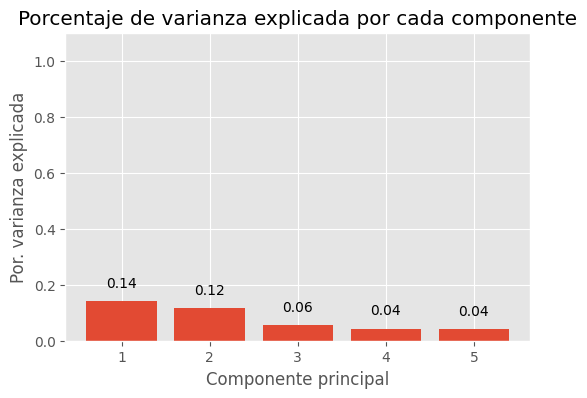

In [25]:
# Pocentaje de varianza explicada por cada componente:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot') or plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(X_train_columns_name)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

El porcentaje de variabilidad que explica cada componente es muy pequeño, por lo que no tiene sentido utilizar las componentes principales como features en la construcción del modelo, ya que estariamos eliminando información valiosa.